In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from transformers import (
    BertTokenizer,
    DataCollatorForLanguageModeling,
    BertForPreTraining,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
import random
import evaluate
import logging
import torch
import nltk
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import os
import shutil
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
RANDOM_SEED = 42

BLOCK_SIZE = 256  # Maximum number of tokens in an input sample
NSP_PROB = 0.50  # Probability that the next sentence is the actual next sentence in NSP ##=> Segun BERT
MAX_LENGTH = 512  # Maximum number of tokens in an input sample after padding
SHORT_SEQ_PROB = 0.1  # Probability of generating shorter sequences to minimize the mismatch between pretraining and fine-tuning.
MLM_PROB = 0.15  # Probability with which tokens are masked in MLM ##=> BERTimbau 0.15

# Entrenaniento
TRAIN_BATCH_SIZE = 128  # Batch-size for pretraining the model on ##=> BERTimbau base 128
EVAL_BATCH_SIZE = 128
MAX_EPOCHS = 40  # Maximum number of epochs to train the model for
WEIGHT_DECAY = 0.01

# Early stopping
ES_PATIENCE = 3
ES_THRESHOLD = 0.001

PATH_DATASET = "unsupervised.csv"
PATH_RESULT_MODEL = "/vol/model"

# Modelo
# Name of pretrained model from 🤗 Model Hub
MODEL_CHECKPOINT = "neuralmind/bert-base-portuguese-cased"

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
metric = evaluate.load("accuracy")

In [3]:
def load_and_prepare_model(model_name="neuralmind/bert-base-portuguese-cased"):
    # Load pre-trained model and tokenizer
    model = BertForPreTraining.from_pretrained(model_name)
    tokenizer = BertTokenizer.from_pretrained(model_name)

    return model, tokenizer

In [4]:

def prepare_train_features(examples, tokenizer):

    #######
    # NSP
    # We define the maximum number of tokens after tokenization that each training sample
    # will have
    max_num_tokens = BLOCK_SIZE - \
        tokenizer.num_special_tokens_to_add(pair=True)

    """Function to prepare features for NSP task

    Arguments:
      examples: A dictionary with 1 key ("text")
        text: List of raw documents (str)
    Returns:
      examples:  A dictionary with 4 keys
        input_ids: List of tokenized, concatnated, and batched
          sentences from the individual raw documents (int)
        token_type_ids: List of integers (0 or 1) corresponding
          to: 0 for senetence no. 1 and padding, 1 for sentence
          no. 2
        attention_mask: List of integers (0 or 1) corresponding
          to: 1 for non-padded tokens, 0 for padded
        next_sentence_label: List of integers (0 or 1) corresponding
          to: 1 if the second sentence actually follows the first,
          0 if the senetence is sampled from somewhere else in the corpus
    """

    # Remove un-wanted samples from the training set
    examples["document"] = [
        d.strip() for d in examples["text"] if len(d) > 0
    ]
    # Split the documents from the dataset into it's individual sentences
    examples["sentences"] = [
        nltk.tokenize.sent_tokenize(document) for document in examples["document"]
    ]
    # Convert the tokens into ids using the trained tokenizer
    examples["tokenized_sentences"] = [
        [tokenizer.convert_tokens_to_ids(
            tokenizer.tokenize(sent)) for sent in doc]
        for doc in examples["sentences"]
    ]

    # Define the outputs
    examples["input_ids"] = []
    examples["token_type_ids"] = []
    examples["attention_mask"] = []
    examples["next_sentence_label"] = []

    for doc_index, document in enumerate(examples["tokenized_sentences"]):

        current_chunk = []  # a buffer stored current working segments
        current_length = 0
        i = 0

        # We *usually* want to fill up the entire sequence since we are padding
        # to `block_size` anyways, so short sequences are generally wasted
        # computation. However, we *sometimes*
        # (i.e., short_seq_prob == 0.1 == 10% of the time) want to use shorter
        # sequences to minimize the mismatch between pretraining and fine-tuning.
        # The `target_seq_length` is just a rough target however, whereas
        # `block_size` is a hard limit.
        target_seq_length = max_num_tokens

        # If your sentences are very long, you might want to adjust these:
        # Increase minimum length for "short" sequences
        target_seq_length = random.randint(2, max_num_tokens)
        
        while i < len(document):
            segment = document[i]
            current_chunk.append(segment)
            current_length += len(segment)
            if i == len(document) - 1 or current_length >= target_seq_length:
                if current_chunk:
                    # `a_end` is how many segments from `current_chunk` go into the `A`
                    # (first) sentence.
                    a_end = 1
                    if len(current_chunk) >= 2:
                        a_end = random.randint(1, len(current_chunk) - 1)

                    tokens_a = []
                    for j in range(a_end):
                        tokens_a.extend(current_chunk[j])

                    tokens_b = []

                    if len(current_chunk) == 1 or random.random() < NSP_PROB:
                        is_random_next = True
                        target_b_length = target_seq_length - len(tokens_a)

                        # This should rarely go for more than one iteration for large
                        # corpora. However, just to be careful, we try to make sure that
                        # the random document is not the same as the document
                        # we're processing.
                        for _ in range(10):
                            random_document_index = random.randint(
                                0, len(examples["tokenized_sentences"]) - 1
                            )
                            if random_document_index != doc_index:
                                break

                        random_document = examples["tokenized_sentences"][
                            random_document_index
                        ]
                        random_start = random.randint(
                            0, len(random_document) - 1)
                        for j in range(random_start, len(random_document)):
                            tokens_b.extend(random_document[j])
                            if len(tokens_b) >= target_b_length:
                                break
                        # We didn't actually use these segments so we "put them back" so
                        # they don't go to waste.
                        num_unused_segments = len(current_chunk) - a_end
                        i -= num_unused_segments
                    else:
                        is_random_next = False
                        for j in range(a_end, len(current_chunk)):
                            tokens_b.extend(current_chunk[j])

                    # Controlar que los tokens no exedan 512
                    if len(tokens_a) > max_num_tokens:
                        tokens_a = tokens_a[0:max_num_tokens]
                    if len(tokens_b) > max_num_tokens:
                        tokens_b = tokens_b[0:max_num_tokens]

                    input_ids = tokenizer.build_inputs_with_special_tokens(
                        tokens_a, tokens_b
                    )
                    # add token type ids, 0 for sentence a, 1 for sentence b
                    token_type_ids = tokenizer.create_token_type_ids_from_sequences(
                        tokens_a, tokens_b
                    )

                    padded = tokenizer.pad(
                        {"input_ids": input_ids, "token_type_ids": token_type_ids},
                        padding="max_length",
                        max_length=MAX_LENGTH,
                    )

                    examples["input_ids"].append(padded["input_ids"])
                    examples["token_type_ids"].append(padded["token_type_ids"])
                    examples["attention_mask"].append(padded["attention_mask"])
                    examples["next_sentence_label"].append(
                        1 if is_random_next else 0)
                    current_chunk = []
                    current_length = 0
            i += 1

    # We delete all the un-necessary columns from our dataset
    del examples["document"]
    del examples["sentences"]
    del examples["text"]
    del examples["tokenized_sentences"]

    return examples

In [5]:
def create_cv_datasets(df, n_splits=5, random_state=RANDOM_SEED):
    """Create cross-validation datasets"""
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    texts = df['text'].values
    
    cv_datasets = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(texts)):
        x_train = pd.Series(texts[train_idx])
        x_val = pd.Series(texts[val_idx])
        
        # Convert to datasets
        train_dataset = Dataset.from_pandas(pd.DataFrame(x_train, columns=['text']))
        val_dataset = Dataset.from_pandas(pd.DataFrame(x_val, columns=['text']))
        
        # Create DatasetDict
        dataset_dict = DatasetDict({'train': train_dataset, 'validation': val_dataset})
        cv_datasets.append(dataset_dict)
    
    return cv_datasets

In [6]:
def prepare_dataset(tokenizer, dataset_dict=None, csv_path=None):
    """Prepare dataset with option to pass DatasetDict directly or create from CSV"""
    if dataset_dict is None and csv_path is not None:
        # Original CSV loading logic
        df = pd.read_csv(csv_path)
        x = df['text'].copy()
        x_train, x_validation = train_test_split(x, test_size=0.2, random_state=RANDOM_SEED)
        
        # Reset indices
        x_train = x_train.reset_index(drop=True)
        x_validation = x_validation.reset_index(drop=True)
        
        # Convert to datasets
        train_dataset = Dataset.from_pandas(pd.DataFrame(x_train, columns=['text']))
        validation_dataset = Dataset.from_pandas(pd.DataFrame(x_validation, columns=['text']))
        
        dataset_dict = DatasetDict({'train': train_dataset, 'validation': validation_dataset})
    
    # Tokenize dataset
    tokenized_dataset = dataset_dict.map(
        lambda examples: prepare_train_features(examples, tokenizer),
        batched=True,
        remove_columns=dataset_dict["train"].column_names,
        num_proc=12
    )
    
    return tokenized_dataset

In [7]:
def preprocess_logits_for_metrics(logits, labels):
    mlm_logits = logits[0]
    nsp_logits = logits[1]
    return mlm_logits.argmax(-1), nsp_logits.argmax(-1)


def compute_metrics(eval_preds):
    preds, labels = eval_preds

    mlm_preds = preds[0]
    nsp_preds = preds[1]

    mlm_labels = labels[0]
    nsp_labels = labels[1]

    mask = mlm_labels != -100
    mlm_labels = mlm_labels[mask]
    mlm_preds = mlm_preds[mask]

    mlm_accuracy = metric.compute(
        predictions=mlm_preds, references=mlm_labels)["accuracy"]
    nsp_accuracy = metric.compute(
        predictions=nsp_preds, references=nsp_labels)["accuracy"]

    return {"Masked ML Accuracy": mlm_accuracy, "NSP Accuracy": nsp_accuracy}


def plot_losses(trainer):
    log_history = trainer.state.log_history
    df_history = pd.DataFrame(log_history)
    set_train_loss = []
    set_val_loss = []
    epochs = int(df_history['epoch'].max())
    for i in range(1, epochs+1):
        index_val = df_history.loc[(
            df_history['epoch'] == i), 'loss'].index.tolist()[0]
        index_train = index_val-1
        train_loss = df_history.loc[index_train, 'loss']
        val_loss = df_history.loc[index_val, 'eval_loss']
        set_train_loss.append(train_loss)
        set_val_loss.append(val_loss)

    # Plot
    loss_index = range(1, len(set_train_loss) + 1)

    plt.figure(figsize=(20, 5))
    plt.plot(loss_index, set_train_loss, label='Train loss')
    plt.plot(loss_index, set_val_loss, label='Val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, len(set_train_loss) + 1))
    plt.legend()
    plt.show()

In [8]:
# Initialize model and tokenizer
model, tokenizer = load_and_prepare_model()

# Prepare dataset
tokenized_dataset = prepare_dataset(tokenizer, csv_path='unsupervised.csv')

# Initialize data collator with NSP
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=MLM_PROB
)


config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map (num_proc=12):   0%|          | 0/15006 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/3752 [00:00<?, ? examples/s]

In [9]:
learning_rates = [
    1e-4,
    1e-5,
    1e-6
]



Training fold 1/5 with learning rate 0.0001


Map (num_proc=12):   0%|          | 0/15006 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/3752 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Masked ml accuracy,Nsp accuracy
1,5.684200,2.523526,0.523973,0.999733
2,2.603800,2.361605,0.544950,0.999733
3,2.440000,2.241006,0.562692,1.000000
4,2.321800,2.184915,0.570594,1.000000
5,2.234700,2.133358,0.579370,1.000000
6,2.089700,2.086559,0.586115,1.000000
7,2.031400,2.054454,0.592041,1.000000
8,1.984700,2.032448,0.595103,1.000000
9,1.939700,1.989144,0.601359,1.000000
10,1.896300,1.994936,0.600754,1.000000


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


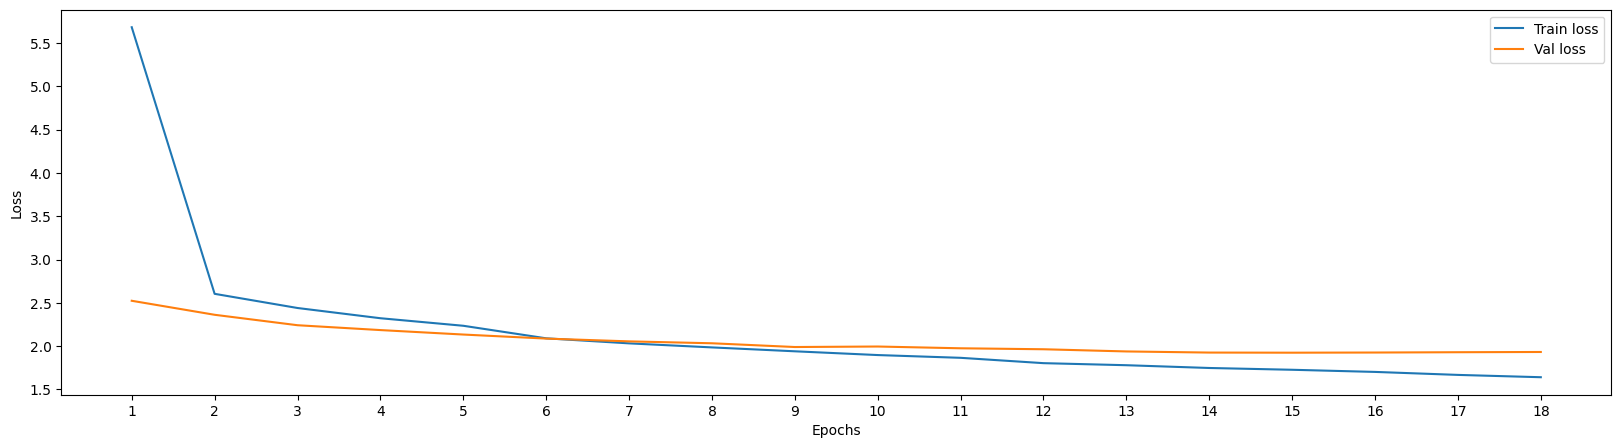


Training fold 2/5 with learning rate 0.0001


Map (num_proc=12):   0%|          | 0/15006 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/3752 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Masked ml accuracy,Nsp accuracy
1,5.679200,2.525810,0.521679,1.000000
2,2.604700,2.350403,0.547403,1.000000
3,2.439400,2.256414,0.560770,1.000000
4,2.324000,2.176168,0.573044,1.000000
5,2.235300,2.117123,0.579252,1.000000
6,2.094600,2.080471,0.586290,1.000000
7,2.032400,2.048592,0.591278,1.000000
8,1.979900,2.040953,0.594388,1.000000
9,1.936200,1.994187,0.600341,1.000000
10,1.899700,1.990219,0.600556,1.000000


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


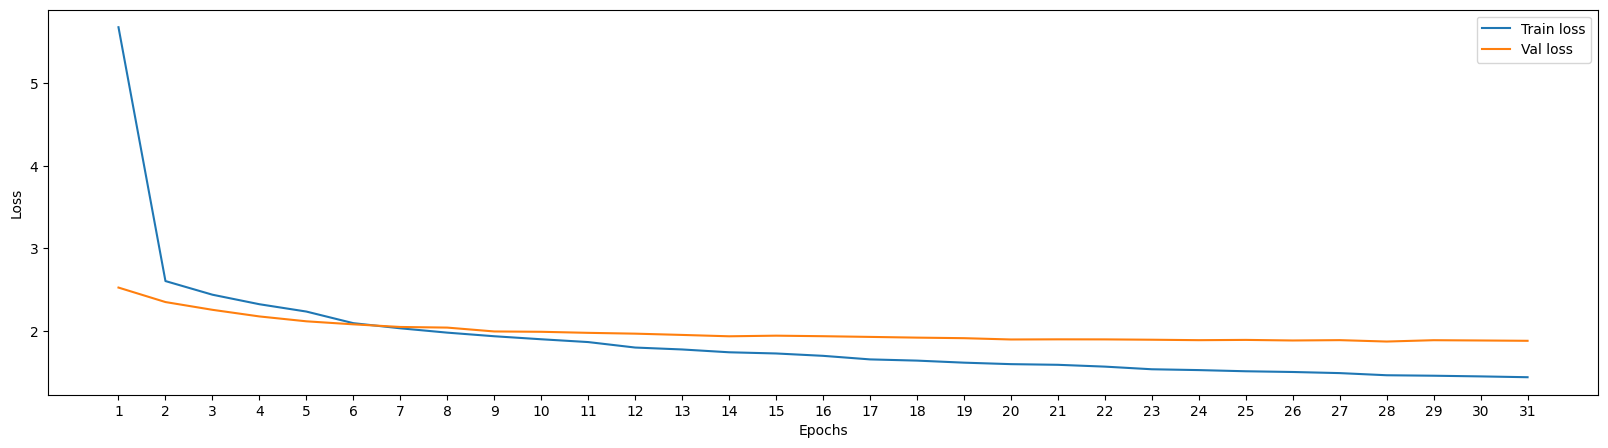


Training fold 3/5 with learning rate 0.0001


Map (num_proc=12):   0%|          | 0/15006 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/3752 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Masked ml accuracy,Nsp accuracy
1,5.670900,2.523469,0.523812,1.000000
2,2.600400,2.358779,0.546250,1.000000
3,2.440100,2.253104,0.561349,1.000000
4,2.333000,2.185814,0.570789,1.000000
5,2.233800,2.130765,0.578488,1.000000
6,2.091000,2.094619,0.586613,1.000000
7,2.029700,2.055181,0.591319,1.000000
8,1.979000,2.031384,0.594780,1.000000
9,1.933500,2.011129,0.599537,1.000000
10,1.894900,2.007456,0.598388,1.000000


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


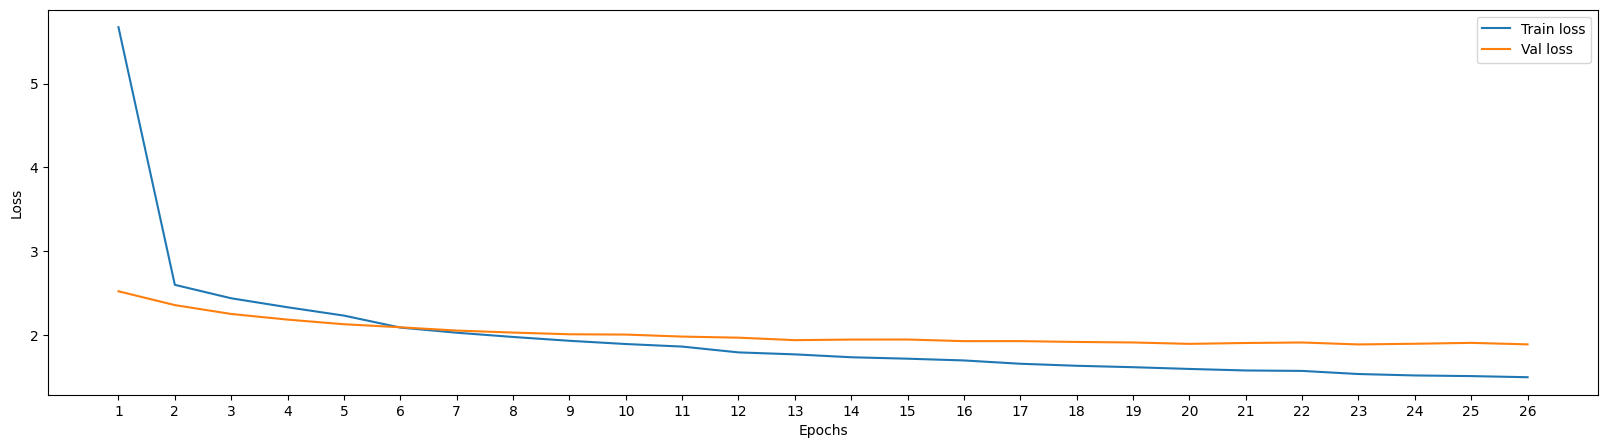


Training fold 4/5 with learning rate 0.0001


Map (num_proc=12):   0%|          | 0/15007 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/3751 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Masked ml accuracy,Nsp accuracy
1,5.686300,2.528984,0.522536,1.000000
2,2.606500,2.345250,0.547457,1.000000
3,2.444000,2.257441,0.560867,1.000000
4,2.328400,2.186921,0.569871,1.000000
5,2.233800,2.136379,0.579681,1.000000
6,2.092600,2.093768,0.584921,1.000000
7,2.037000,2.051098,0.590498,1.000000
8,1.982000,2.036965,0.594289,1.000000
9,1.935400,2.006668,0.598432,1.000000
10,1.902300,1.990403,0.601396,1.000000


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


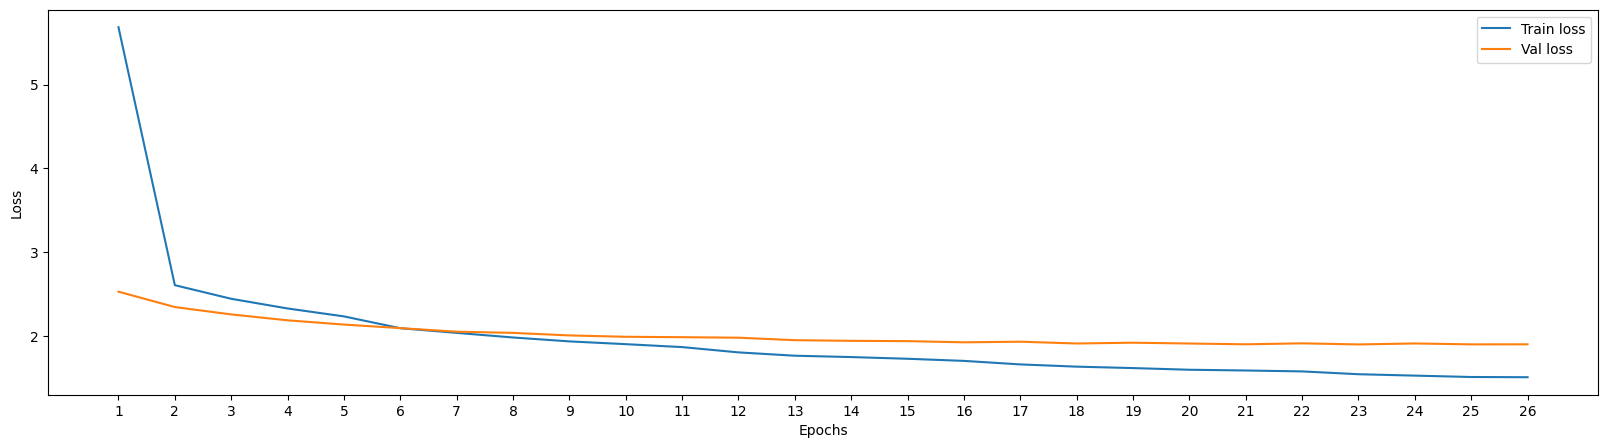


Training fold 5/5 with learning rate 0.0001


Map (num_proc=12):   0%|          | 0/15007 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/3751 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Masked ml accuracy,Nsp accuracy
1,5.678200,2.521667,0.522750,1.000000
2,2.598500,2.348855,0.547135,1.000000
3,2.441700,2.233224,0.563157,1.000000
4,2.329800,2.168354,0.573576,1.000000
5,2.231300,2.119642,0.580343,1.000000
6,2.088200,2.073912,0.586929,1.000000
7,2.028800,2.043612,0.592038,1.000000
8,1.984200,2.021159,0.597117,1.000000
9,1.940100,1.999916,0.600836,1.000000
10,1.901600,1.981702,0.602649,1.000000


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


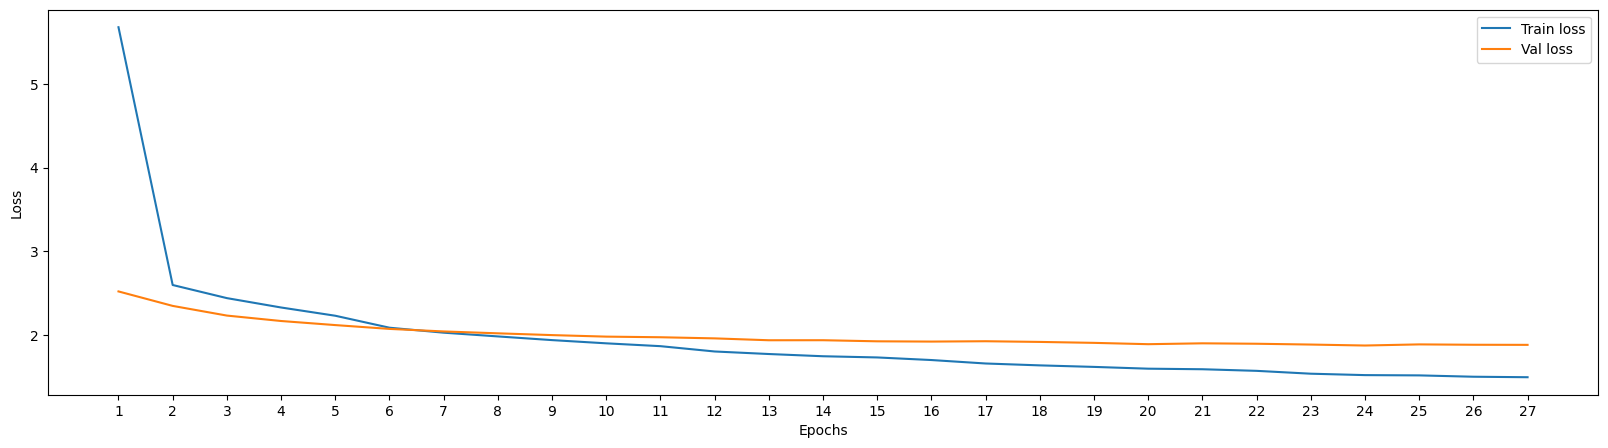

INFO:__main__:Average metrics for learning rate 0.0001: {'train_runtime': 1260.72534, 'train_samples_per_second': 491.9646000000001, 'train_steps_per_second': 3.8684, 'total_flos': 1.0181181084837397e+17, 'train_loss': 1.9709263917815363, 'epoch': 25.6}



Training fold 1/5 with learning rate 1e-05


Map (num_proc=12):   0%|          | 0/15006 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/3752 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Masked ml accuracy,Nsp accuracy
1,10.736400,3.715295,0.394091,0.990139


KeyboardInterrupt: 

In [10]:
# Load the data once
df = pd.read_csv('unsupervised.csv')
cv_datasets = create_cv_datasets(df, n_splits=5)

for learning_rate in learning_rates:
    cv_results = []
    
    for fold, dataset_dict in enumerate(cv_datasets):
        print(f"\nTraining fold {fold+1}/5 with learning rate {learning_rate}")
        
        # Initialize fresh model for each fold
        model, tokenizer = load_and_prepare_model()
        
        # Prepare dataset for this fold
        tokenized_dataset = prepare_dataset(tokenizer, dataset_dict=dataset_dict)
        
        # Calculate steps (same as before)
        total_train_samples = len(tokenized_dataset["train"])
        num_update_steps_per_epoch = total_train_samples // TRAIN_BATCH_SIZE
        total_training_steps = num_update_steps_per_epoch * MAX_EPOCHS
        warmup_steps = total_training_steps // 10
        
        training_args = TrainingArguments(
        output_dir=PATH_RESULT_MODEL,
        logging_first_step=True,
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        weight_decay=WEIGHT_DECAY,
        per_device_train_batch_size=TRAIN_BATCH_SIZE,
        per_device_eval_batch_size=EVAL_BATCH_SIZE,
        logging_steps=100,
        bf16=True,
        save_strategy="epoch",
        num_train_epochs=MAX_EPOCHS,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        # Add these parameters
        warmup_steps=warmup_steps,
        lr_scheduler_type="linear",
        )
        
        early_stop = EarlyStoppingCallback(
            early_stopping_patience=ES_PATIENCE, 
            early_stopping_threshold=ES_THRESHOLD
        )
        
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_dataset['train'],
            eval_dataset=tokenized_dataset['validation'],
            data_collator=data_collator,
            compute_metrics=compute_metrics,
            preprocess_logits_for_metrics=preprocess_logits_for_metrics,
            callbacks=[early_stop]
        )
        
        # Train and evaluate
        train_result = trainer.train()
        cv_results.append(train_result.metrics)
        
        # Plot losses for this fold
        plot_losses(trainer)
        
        # Save the model for this fold
        model.save_pretrained(f"{PATH_RESULT_MODEL}/final_model_lr{learning_rate}_fold{fold+1}")
        tokenizer.save_pretrained(f"{PATH_RESULT_MODEL}/final_model_lr{learning_rate}_fold{fold+1}")
    
    # Calculate and log average metrics across folds
    avg_metrics = {k: np.mean([r[k] for r in cv_results]) for k in cv_results[0].keys()}
    logger.info(f"Average metrics for learning rate {learning_rate}: {avg_metrics}")